## Safety Filters
This notebook showcases the usage of [invariance-based safety filters](../ampyc/controllers/ibsf.py) [1], possibly with discrete-time contol barrier function constraint [2], and [predictive safety filters](../ampyc/controllers/psf.py) [3].

[1] K. P. Wabersich, and M. N. Zeilinger. "Scalable synthesis of safety certificates from data with application to learning-based control." 2018 European control conference (ECC). IEEE, 2018.

[2] A. Agrawal, and K. Sreenath. "Discrete control barrier functions for safety-critical control of discrete systems with application to bipedal robot navigation." Robotics: Science and Systems. Vol. 13. 2017.

[3] K. P. Wabersich, and M. N. Zeilinger. "Linear model predictive safety certification for learning-based control." 2018 IEEE Conference on Decision and Control (CDC). IEEE, 2018.

### Define unsafe performance input and simulate

We first define an input sequence which we would like to apply to our system. This input sequence will cause constraint violations, which we will avoid using safety filters.

In [1]:
# import numpy utilities
import numpy as np

# import the safety-filter parameters, system model
from ampyc.params import SFParams
from ampyc.systems import LinearSystem

# import plotting helpers
from ampyc.plotting import plot_x_state_time, plot_x_state_state, plot_u, plot_sf


#### Instantiate the linear system

We load the default safety-filter parameters and build the associated linear system model that defines the plant dynamics and its state/input constraints.


In [2]:
params = SFParams()
sys = LinearSystem(params.sys)

Successfully initialized experiment 'safety filter'.


#### Define the performance input

To benchmark the safety filter, we define a sinusoidal input sequence that we would ideally like to apply in the absence of any safety considerations.


In [3]:
u_L = np.sin(0.5*np.pi*params.sys.dt*np.arange(0, params.sim.num_steps))

#### Simulate the open-loop response

We propagate the linear system with the performance input alone first.


In [4]:
# collect simulation settings
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# propagate the system with the performance input only
for i in range(num_traj):
    for j in range(num_steps):
        u[j,i] = u_L[j]                  # apply unfiltered input
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

#### Visualize the open-loop trajectories

We plot state and performance input trajectories, where we can observe that the state constraints are violated.

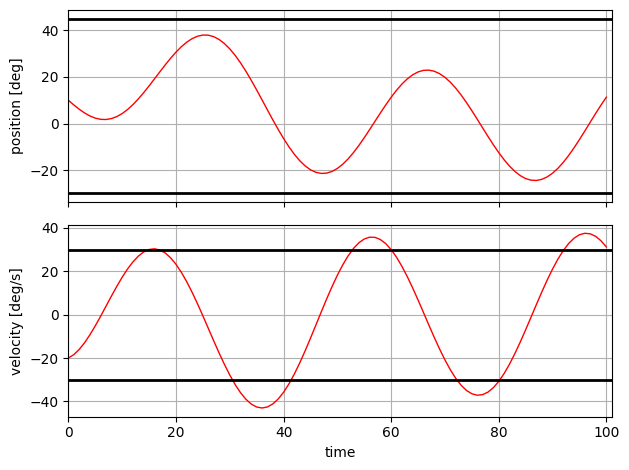

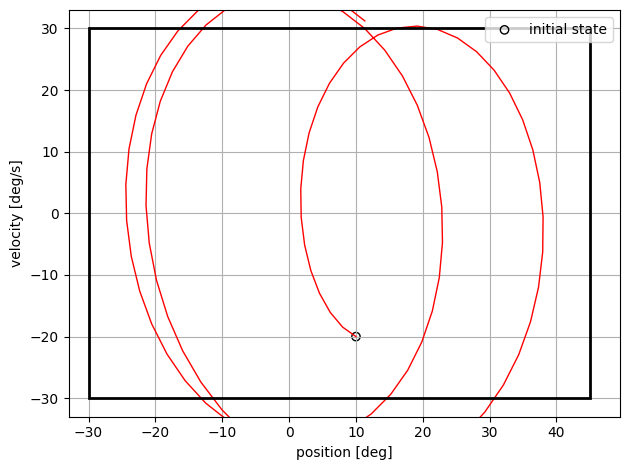

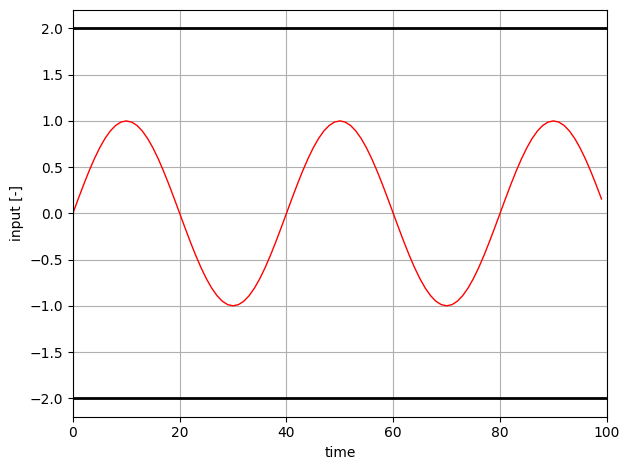

In [5]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X

# plot the closed-loop state and input trajectories
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'])

### Invariance-based Safety Filter simulation

#### Instantiate the safety filter

The IBSF controller enforces the state and input constraints by overwriting the performance input with a safe controller whenever a violation is imminent.


In [6]:
# import invariance-based safety filter
from ampyc.controllers import IBSF

In [7]:
ctrl_IBSF = IBSF(sys, params.ctrl)

#### Simulate the closed-loop system with IBSF

We now close the loop by feeding the performance input through the IBSF at every step and propagating the filtered command through the plant.


In [8]:
# collect simulation settings
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# close the loop with the safety filter
for i in range(num_traj):
    for j in range(num_steps):
        sol_u = ctrl_IBSF.solve(sys, x[j,:,i], u_L[j].reshape(-1))  # filter performance input
        u[j,i] = sol_u.squeeze()
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

#### Visualize the filtered trajectories

Comparing the filtered state/input trajectories with the unsafe performance input showcases how IBSF ensures constraint violation by modifying the input. Note how due to the switching mechanism for the filtered inputs, the control signal becomes unsmooth.


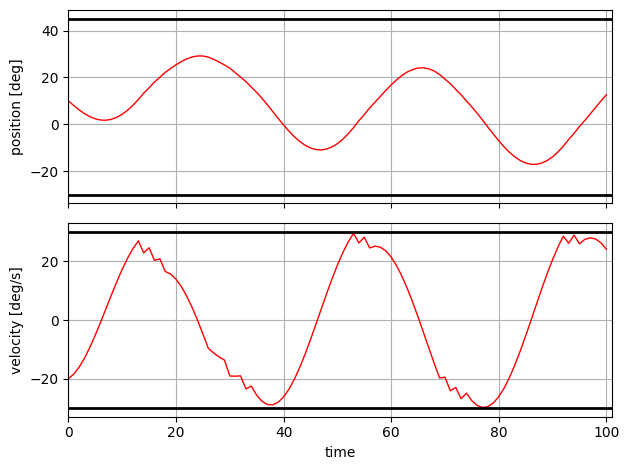

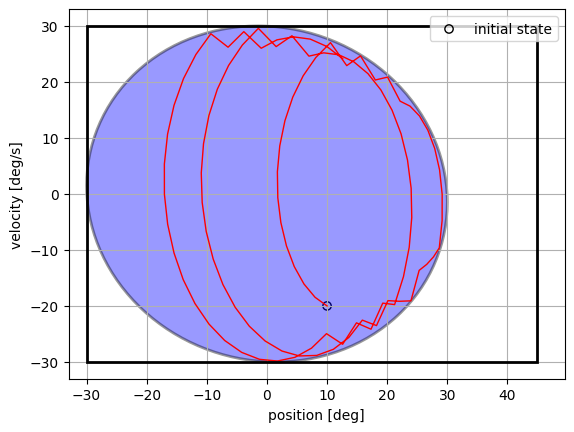

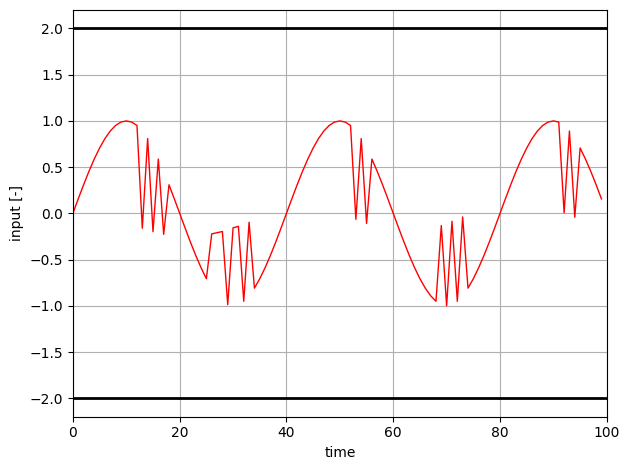

In [9]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X
P_deg = ctrl_IBSF.P / (180/np.pi)**2

# plot the closed-loop state and input trajectories
plot_x_state_time(4, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_sf(5, x_deg, X_deg, P_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(6, u, sys.U, params.plot, axes_labels=['input [-]'])

### Minimally invasive IBSF simulation

The minimally invasive IBSF solves an optimization problem, minimizing the distance of the input applied to the system with the performance input to filter the inputs as little as possible while maintaining safety.

In [10]:
# import minimally invasive invariance-based safety filter
from ampyc.controllers import MinIBSF

In [11]:
ctrl_IBSF_min = MinIBSF(sys, ctrl_IBSF.P, params.ctrl)

#### Simulate the closed-loop system with minimally invasive IBSF

We now close the loop by feeding the performance input through the minimally invasive IBSF at every step and propagating the filtered command through the plant.


In [12]:
# trajectories starting in x_0
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# control-loop
for i in range(num_traj):
    for j in range(num_steps):
        additional_params = {
            'u_L': u_L[j].reshape(-1)
        }
        sol_u, _, error_msg = ctrl_IBSF_min.solve(x[j,:,i], additional_parameters = additional_params)
        if error_msg:
            raise Exception(error_msg)
        u[j,i] = sol_u.squeeze()
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

#### Visualize the filtered trajectories

Comparing the filtered state/input trajectories with the unsafe performance input showcases how IBSF ensures constraint violation by modifying the input. Note how the input signal is smoother for the minimally invasive IBSF compared to the switching approach. Additionally, note how the filter only intervenes when the system state is about to exit the safe set.

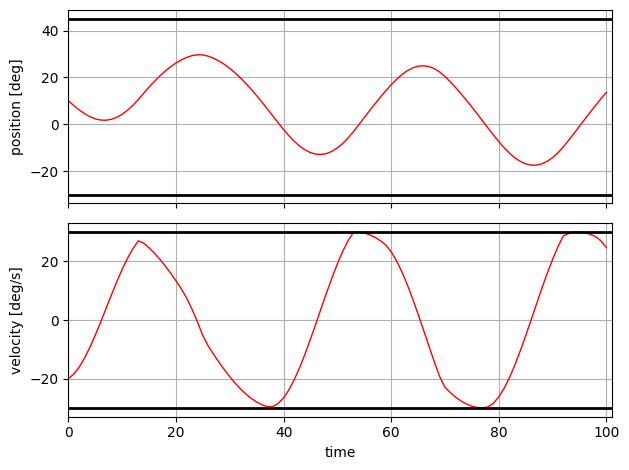

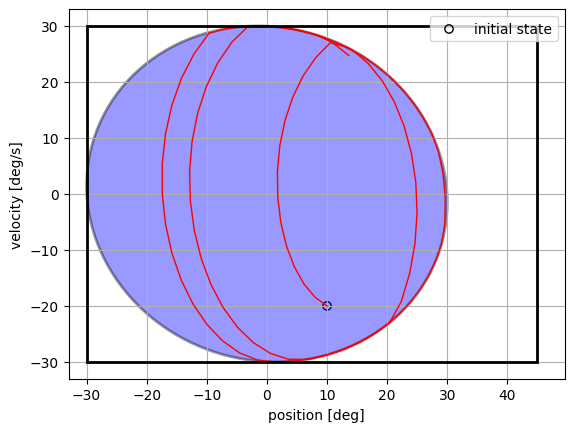

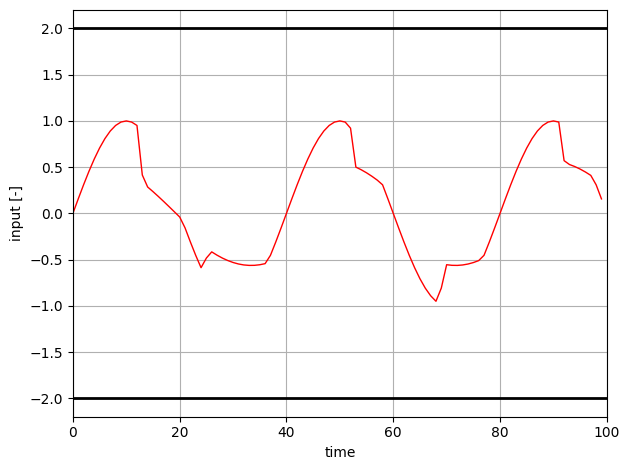

In [13]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X
P_deg = ctrl_IBSF.P / (180/np.pi)**2

# plot the closed-loop state and input trajectories
plot_x_state_time(7, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_sf(8, x_deg, X_deg, P_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(9, u, sys.U, params.plot, axes_labels=['input [-]'])

### IBSF with dampening constraint

Instead of intervening only when the system is safe, it may be beneficial to dampen the system's approach to the boundary of the safe set through an additional dampening constraint.

In [14]:
# import invariance-based safety filter with dampening constraint
from ampyc.controllers import DampIBSF

In [15]:
# define a dampening parameter, feel free to play around with it
gamma = 0.3

ctrl_IBSF_damp = DampIBSF(sys, ctrl_IBSF.P, params.ctrl, gamma)

##### Simulate the closed-loop system with IBSF with dampening constraint

We now close the loop by feeding the performance input through the IBSF with dampening constraint at every step and propagating the filtered command through the plant.

In [16]:
# trajectories starting in x_0
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# control-loop
for i in range(num_traj):
    for j in range(num_steps):
        additional_params = {
            'u_L': u_L[j].reshape(-1),
            'V_x_0': x[j,:,i].T @ ctrl_IBSF_damp.P @ x[j,:,i] # here we compute the quadratic form at x_0 of the invariant ellipsoid to respect DPP in the optimization problem
        }
        
        sol_u, _, error_msg = ctrl_IBSF_damp.solve(x[j,:,i], additional_parameters = additional_params)
        if error_msg:
            raise Exception(error_msg)
        u[j,i] = sol_u.squeeze()
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

#### Visualize the filtered trajectories

Note how the dampening constraint makes the safety filter intervene earlier, resulting in a smoother state trajectory towards the boundary of the safe set.

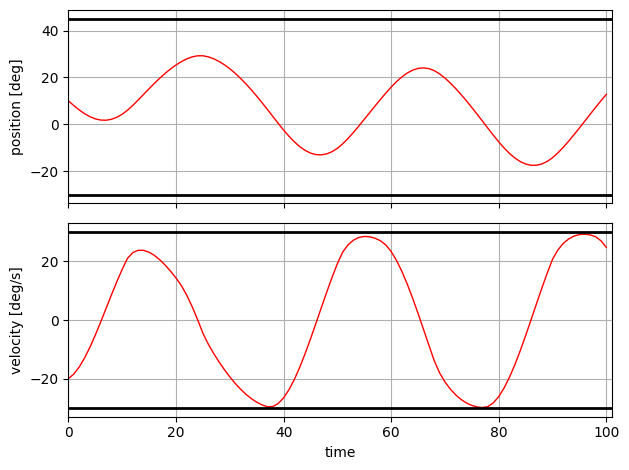

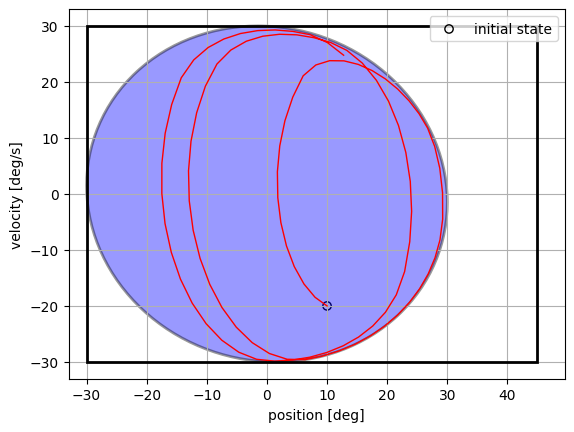

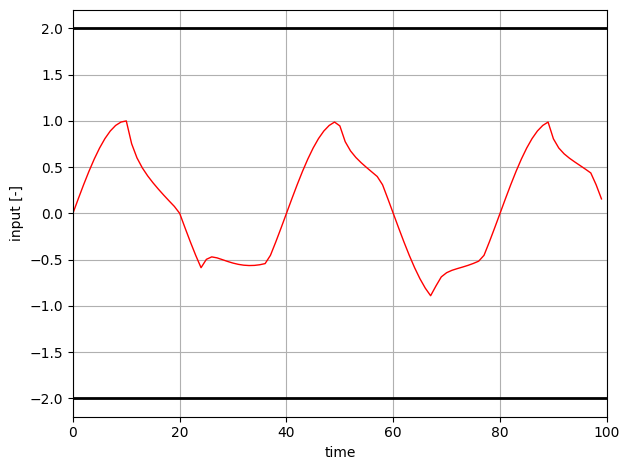

In [17]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X
P_deg = ctrl_IBSF.P / (180/np.pi)**2

# plot the closed-loop state and input trajectories
plot_x_state_time(10, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_sf(11, x_deg, X_deg, P_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(12, u, sys.U, params.plot, axes_labels=['input [-]'])

### Model Predictive Safety Filter

Invariance-based safety filters restrict the system state to lie within an explicit formulation of a safe set. By leveraging model predictive control techniques, we can plan a trajectory towards this explicit safe set. Thereby, states which are outside the safe set but can reach it within the time horizon without violating the constraints are still safe.

In [18]:
# import predictive safety filter
from ampyc.controllers import PSF

In [19]:
ctrl_PSF = PSF(sys, params.ctrl, ctrl_IBSF.P)

##### Simulate the closed-loop system with predictive safety filter

We now close the loop by feeding the performance input through the predictive safety filter at every step and propagating the filtered command through the plant.

In [20]:
# trajectories starting in x_0
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
x_0 = params.sim.x_0

# here we can also start outside of the terminal safe set, e.g.:
# x_0 = np.array([np.deg2rad(-20), np.deg2rad(-20)]).reshape(-1,1)


# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# control-loop
for i in range(num_traj):
    for j in range(num_steps):
        additional_params = {
            'u_L': u_L[j].reshape(-1)
        }
        
        sol_u,_, error_msg = ctrl_PSF.solve(x[j,:,i], additional_parameters = additional_params)
        
        if error_msg:
            raise Exception(error_msg)
        
        u[j,i] = sol_u[:,0].squeeze()
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

#### Visualize the filtered trajectories

Comparing the filtered state trajectories with the invariance-based safety filters, notice how the closed-loop system satisfies the state constraints, but is able to operate outside the explicit safe set.

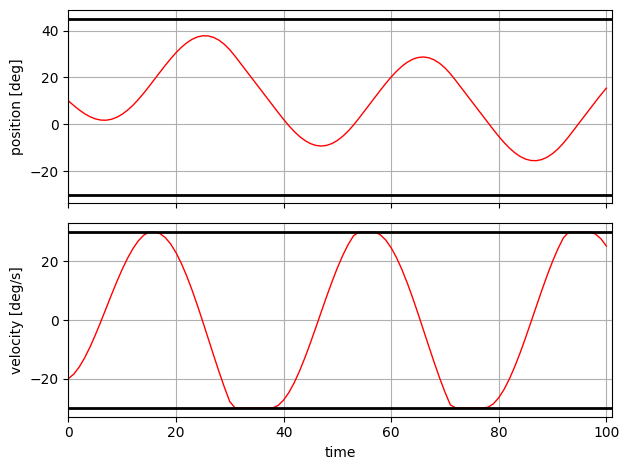

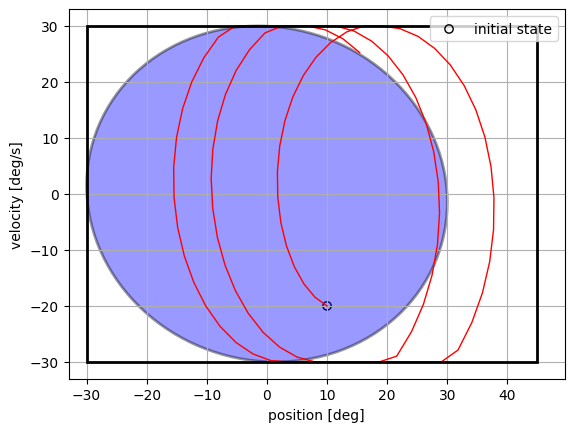

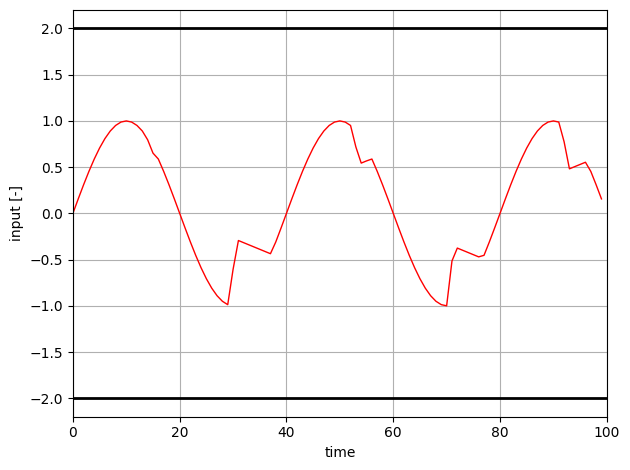

In [21]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X
P_deg = ctrl_IBSF.P / (180/np.pi)**2

# plot the closed-loop state and input trajectories
plot_x_state_time(10, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_sf(11, x_deg, X_deg, P_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(12, u, sys.U, params.plot, axes_labels=['input [-]'])